# Text generation using Mixture of Experts

*Copyright (c) 2023 Graphcore Ltd.*

As models get larger and more capable, they get increasingly more expensive to train and run due to the large computational costs accompanying the increase in the number of parameters. **Mixture of Experts (MoE)** is a technique that aims at addressing this by only activating a subset of the network (i.e., different experts) based on the input, thus drastically decreasing the computational costs by selecting only the appropriate subnetwork for each input.

This notebook outlines a character-level text generation model in PyTorch, showing how, starting from a standard model definition, we can define a mixture of experts model running on both IPU and CPU. Following the tutorial you will:

* Define a light character-level language model and train it on WikiText-103 data.
* Learn how to write the standard MoE execution scheme in PyTorch (based on [Switch Transformers](https://arxiv.org/abs/2101.03961)).
* Adapt the language model to run MoE, train and run the models on both IPU and CPU, and observe the improvements in performance.

By the end of the tutorial you will be familiar with all the main aspects of the mixture of experts execution scheme and be able to adapt arbitrary PyTorch layers to incorporate it. You will also learn about the distributed MoE training on the IPUs and how to utilise multiple devices to increase the capacity of the model.

## Installation

Let's start with installing the required modules:

In [ ]:
%pip install -q numpy torch matplotlib
%pip install -q git+https://github.com/graphcore-research/poptorch-experimental-addons@14886d2285c3e45b0eadf4d719dae87d5f28b109

We will also download the dataset and model checkpoints:

In [ ]:
%%bash
wget -q -P /tmp/ https://graphcore-research-public.s3.eu-west-1.amazonaws.com/2023-moe-notebook/wikitext103.zip
unzip /tmp/wikitext103.zip -d /tmp/dataset_cache/
rm /tmp/wikitext103.zip
wget -q -P /tmp/ https://graphcore-research-public.s3.eu-west-1.amazonaws.com/2023-moe-notebook/checkpoints.zip
unzip /tmp/checkpoints.zip -d /tmp/
rm /tmp/checkpoints.zip

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import poptorch
import os
from pathlib import Path
from dataclasses import dataclass
from typing import Tuple, Optional
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [6]:
dataset_dir = Path(os.getenv("DATASET_DIR"))
checkpoint_dir = Path(os.getenv("CHECKPOINT_DIR"))

## Dataset

For training, we use the freely-available character-level `WikiText-103` dataset that can be downloaded from [here](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/). In order to load and batch the data, we can use `Dataset` class from `data.py`. The class requires a corresponding character-level vocabulary that we will use to convert between the characters and the corresponding integer indices. In this case, the vocabulary is pre-defined in `vocab.json` and it contains all 5,008 different characters appearing in `WikiText-103`. Internally, `Dataset` class uses the `CharVocab` class from `data.py` to provide the `str_to_ids` and `ids_to_str` methods for converting between text and an array of character ids:

In [7]:
from data import CharVocab

vocab = CharVocab.from_path(dataset_dir / "wikitext103_raw/vocab.json")
print(f"Number of characters in the vocabulary: {len(vocab):,}")

some_text = "Hello world"
char_ids = vocab.str_to_ids(some_text)

print(f"{some_text} -> {char_ids} -> {vocab.ids_to_str(char_ids)}")

Number of characters in the vocabulary: 5,008
Hello world -> tensor([41, 70, 77, 77, 80,  1, 88, 80, 83, 77, 69]) -> Hello world


When defining a `Dataset` object, we need to pass the text and the vocabulary (which will internally be converted to a `CharVocab` object). Let's load up the `validation` dataset to see how it works (it is smaller than the training data so will load more quickly).

**Note**: When the dataset is loaded, the whole text is processed and converted to integer ids - this may take a bit of time.

#### Load the dataset

In [8]:
from data import Dataset

vocab_path = dataset_dir / "wikitext103_raw/vocab.json"
text_path = dataset_dir / "wikitext103_raw/valid.txt"

ds = Dataset.from_path(vocab_path, text_path)

print(f"Number of characters in the dataset: {len(ds):,}")

Number of characters in the dataset: 1,144,748


#### Batching the data

Now that we have our `Dataset` object, we can call the `batch()` method in order to return an iterator that will sequentially generate batches of our training, validation, or test data. For the `batch` method, we need to pass the `batch_size` (number of sequences in a batch), `sequence_length` (number of characters per sequence), as well as `overlap_length` (number of characters that overlap between consecutive sequences). Note that this means that start indices of consecutive sequences will be `sequence_length - overlap_length` characters apart. In addition, we can pass a `seed` parameter to randomly generate the order of batched sequences - leaving it to `None` will instead generate sequences in the order of appearance within the dataset.

Each batch will consist of an input/target pair of character id sequences (where for each input, the target is shifted one place to the left, i.e. corresponding to the next character in the sequence), as well as a mask tensor that masks out the first `overlap_length` number of characters in each sequence - we will use this during training in order to prevent the first `overlap_length` character predictions to contribute to the model loss.

In [11]:
batch_size = 8
sequence_length = 256
overlap_length = 32
seed = 100

batch = next(
    ds.batch(
        batch_size,
        sequence_length,
        overlap_length,
        seed,
    )
)
x = batch["x"]
y = batch["y"]
mask = batch["mask"]

print(f"Shape of the input: {x.shape}")
print(f"Shape of the output: {y.shape}\n")

seq_num = 1
print("Example input sequence:\n", ds.vocab.ids_to_str(x[seq_num]), '\n')
print("Example target sequence:\n", ds.vocab.ids_to_str(y[seq_num]), '\n')
print("Sequence mask:\n", mask[seq_num])

Shape of the input: torch.Size([8, 256])
Shape of the output: torch.Size([8, 256])

Example input sequence:
 st Banksy who produced the opening sequence of an earlier Simpsons episode titled " MoneyBART " ( 2010 ) . The Richard Hawley song " Tonight The Streets Are Ours " , which is the theme song of Exit Through the Gift Shop , is included in the episode during  

Example target sequence:
 t Banksy who produced the opening sequence of an earlier Simpsons episode titled " MoneyBART " ( 2010 ) . The Richard Hawley song " Tonight The Streets Are Ours " , which is the theme song of Exit Through the Gift Shop , is included in the episode during a 

Sequence mask:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.,

## Baseline model

Let's start by defining the character-level text-generation baseline model. In this example we will use a simplified transformer-style architecture where instead of a multi-head attention block we use a causal one-dimensional convolutional layer. We construct the model by alternating convolutional and FFN layers.

<p align="center">
<img src="./figs/fig1.png"  width="600" >
</p>

#### Convolutional layer

In order to construct a *causal* convolution, we use a regular `nn.Conv1d` layer with `in_channels=hidden_size` and `out_channels=hidden_size`, with the setting `padding=kernel_size - 1` which ensures that the output at each position in the sequence only depends on the *previous* characters in the input sequence. As this leads to additional dummy elements at the end of each sequence, we cut the last `kernel_size - 1` characters in the `forward` method. Note that additional reshaping and axis permutations need to be done in the `forward` method to align with the expected `Conv1d` input order.

In [12]:
class CausalConv1d(nn.Conv1d):
    """Conv1d layer with left padding to enforce causality"""

    def __init__(
        self,
        hidden_size: int,
        kernel_size: int,
        num_groups: int,
        dtype: torch.dtype,
    ):
        super().__init__(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size,
            padding=kernel_size - 1,
            groups=num_groups,
            dtype=dtype,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.transpose(-1, -2)
        x = super().forward(x)[..., : -(self.kernel_size[0] - 1)]
        return x.transpose(-1, -2)

#### FFN layer

For the FFN layer, we will use the standard transformer structure of an up and down projection with a nonlinearity in between. For this it's useful to define helper functions for initialising the layer weights and biases tensors.

In [13]:
def create_weight_tensor(shape: Tuple[int, ...], dtype: torch.dtype) -> nn.Parameter:
    w = nn.Parameter(torch.empty(shape, dtype=dtype))
    xavier_std = np.sqrt(2 / (shape[-2] + shape[-1]))
    return nn.init.normal_(w, mean=0, std=xavier_std)


def create_bias_tensor(out_features: int, dtype: torch.dtype) -> nn.Parameter:
    b = nn.Parameter(torch.empty(out_features, dtype=dtype))
    return nn.init.zeros_(b)

In [14]:
class FFN(nn.Module):
    """Transformer-style FFN layer"""

    def __init__(self, hidden_size: int, expand_factor: int, dtype: torch.dtype):
        super().__init__()
        self.hidden_size, self.expand_factor, self.dtype = (
            hidden_size,
            expand_factor,
            dtype,
        )
        self.w1 = create_weight_tensor(
            (hidden_size, hidden_size * expand_factor), dtype
        )
        self.w2 = create_weight_tensor(
            (hidden_size * expand_factor, hidden_size), dtype
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(x @ self.w1) @ self.w2

#### Putting it all together

Now that we have defined our convolutional and FFN layers, we can build the core layer of our model following the Transformer recipe: sequence of `CausalConv1d` and `FFN` layers with residual connections and layer normalizations between.

In [15]:
class CoreLayer(nn.Module):
    """Core model layer consisting of Conv1D + normalization + FFN"""

    def __init__(
        self,
        hidden_size: int,
        expand_factor: int,
        kernel_size: int,
        num_groups: int,
        dtype: torch.dtype,
    ):
        super().__init__()

        self.ffn = FFN(
            hidden_size=hidden_size, expand_factor=expand_factor, dtype=dtype
        )
        self.conv = CausalConv1d(
            hidden_size=hidden_size,
            kernel_size=kernel_size,
            num_groups=num_groups,
            dtype=dtype,
        )
        self.layer_norm1 = nn.LayerNorm(hidden_size, dtype=dtype)
        self.layer_norm2 = nn.LayerNorm(hidden_size, dtype=dtype)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_conv = F.relu(self.conv(x))
        x = self.layer_norm1(x_conv + x)
        x_ffn = self.ffn(x)
        return self.layer_norm2(x_ffn + x)

The full model will now consist of a sequence of `CoreLayer` layers, with an additional `nn.Embedding` for the input embeddings, and a linear output projection from `hidden_size` to `vocab_size`. We additionally define the `masked_cross_entropy_loss` method in order to ignore the loss contributions of the characters based on the previously generated `mask`.

In order to ensure our model can run on both IPUs and CPU we need to calculate and return the loss function within our `forward` method, as well as to wrap it within `poptorch.identity_loss` function.

In [16]:
class CharModel(nn.Module):
    """Character-level language model"""

    def __init__(
        self,
        vocab_size: int,
        hidden_size: int,
        expand_factor: int,
        kernel_size: int,
        num_groups: int,
        num_layers: int,
        dtype: torch.dtype,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, hidden_size, dtype=dtype)
        self.core_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.core_layers.append(
                CoreLayer(
                    hidden_size=hidden_size,
                    expand_factor=expand_factor,
                    kernel_size=kernel_size,
                    num_groups=num_groups,
                    dtype=dtype,
                )
            )
        self.w_out = create_weight_tensor(shape=(hidden_size, vocab_size), dtype=dtype)
        self.b_out = create_bias_tensor(out_features=vocab_size, dtype=dtype)

    def masked_cross_entropy_loss(
        self, logits: torch.Tensor, y: torch.Tensor, mask: torch.Tensor
    ) -> torch.Tensor:
        batch_loss = F.cross_entropy(
            logits.reshape((-1, self.vocab_size)),
            y.reshape(-1),
            reduction="none",
        )
        return (batch_loss * mask.reshape(-1)).sum() / mask.sum()

    def forward(
        self, x: torch.Tensor, mask: torch.Tensor = None, y: torch.Tensor = None
    ) -> torch.Tensor:
        embed = self.embedding(x)
        for layer in self.core_layers:
            embed = layer(embed)
        logits = embed @ self.w_out + self.b_out

        if self.training:
            loss = self.masked_cross_entropy_loss(logits, y, mask)
            return logits, poptorch.identity_loss(loss, reduction="none")

        return logits

#### Training the model *(can be skipped)*



Now that we have defined all modules of our model, we can build and train the model on the `WikiText-103` dataset.

For training, we use the `AdamW` optimiser with learning rate decay. The following code showcases a basic training loop with these settings, making sure that the model is wrapped within `poptorch.trainingModel` when executing on the IPU. Note that running on the CPU is very slow and is mainly provided as a reference.

In [17]:
# Training settings
@dataclass
class BatchSettings:
    batch_size: int = 32
    sequence_length: int = 256
    overlap_length: int = 32
    batch_seed: int = 100

class TrainingSettings:
    lr: float = 2e-3
    lr_decay: float = 2**-16
    num_steps: int = 2**15

class DeviceSettings:
    run_on_ipu: bool = True
    num_replicas: int = 4
    
class Settings:
    batch: BatchSettings = BatchSettings()
    training: TrainingSettings = TrainingSettings()
    device: DeviceSettings = DeviceSettings()

In [206]:
def train(model: CharModel, data: Dataset, settings: Settings):
    model.train()

    # Set the optimizer
    if settings.device.run_on_ipu:
        opts = poptorch.Options()
        opts.replicationFactor(settings.device.num_replicas)
        optimizer = poptorch.optim.AdamW(model.parameters(), lr=settings.training.lr)
        poptorch_model = poptorch.trainingModel(model, opts, optimizer)
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=settings.training.lr)

    # Training loop
    lr = settings.training.lr
    lr_decay_factor = 2**-settings.training.lr_decay
    training_loss = {}
    for step, batch in zip(
        range(settings.training.num_steps),
        data.batch(
            settings.batch.batch_size,
            settings.batch.sequence_length,
            settings.batch.overlap_length,
            settings.batch.batch_seed,
        ),
    ):
        # Apply a step
        if settings.device.run_on_ipu:
            out, loss = poptorch_model(
                batch["x"].int(), batch["mask"], batch["y"].int()
            )
            loss = torch.mean(loss)  # average over IPUs if num_replicas > 1
        else:
            optimizer.zero_grad()
            out, loss = model(batch["x"], batch["mask"], batch["y"])
            loss.backward()
            optimizer.step()

        training_loss[step + 1] = loss.detach()

        # Print results
        if (step + 1) % 2**8 == 0:
            print(f"Step {step + 1}:")
            print(f"Loss: {loss.detach()}")

        # Learning rate schedule
        lr *= lr_decay_factor
        optimizer.param_groups[0]["lr"] = lr
        if settings.device.run_on_ipu:
            poptorch_model.setOptimizer(optimizer)

    if settings.device.run_on_ipu:
        poptorch_model.destroy()

    return model, training_loss

In [207]:
run_training = True

In [208]:
# Load the training dataset
if run_training:
    vocab_path = dataset_dir / "wikitext103_raw/vocab.json"
    train_path = dataset_dir / "wikitext103_raw/train.txt"
    train_ds = Dataset.from_path(vocab_path, train_path)

Graph compilation: 100%|██████████| 100/100 [00:01<00:00]


Step 256:
Loss: 1.8835697174072266

Step 512:
Loss: 1.5806868076324463

Step 768:
Loss: 1.5531970262527466

Step 1024:
Loss: 1.5493698120117188

Step 1280:
Loss: 1.484054684638977

Step 1536:
Loss: 1.4452996253967285

Step 1792:
Loss: 1.4192562103271484

Step 2048:
Loss: 1.3834298849105835

Step 2304:
Loss: 1.385108470916748

Step 2560:
Loss: 1.3280918598175049

Step 2816:
Loss: 1.457467794418335

Step 3072:
Loss: 1.3540315628051758

Step 3328:
Loss: 1.294749140739441

Step 3584:
Loss: 1.3537369966506958

Step 3840:
Loss: 1.3362096548080444

Step 4096:
Loss: 1.3122296333312988

Step 4352:
Loss: 1.3033356666564941

Step 4608:
Loss: 1.3163139820098877

Step 4864:
Loss: 1.2624539136886597

Step 5120:
Loss: 1.3184340000152588

Step 5376:
Loss: 1.300741195678711

Step 5632:
Loss: 1.3799368143081665

Step 5888:
Loss: 1.2994341850280762

Step 6144:
Loss: 1.284032940864563

Step 6400:
Loss: 1.3321866989135742

Step 6656:
Loss: 1.3044580221176147

Step 6912:
Loss: 1.2541359663009644

Step 7168:

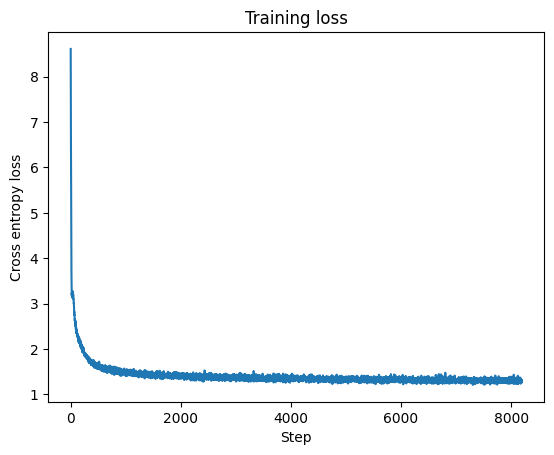

In [209]:
if run_training:
    # Create the model

    # Set random seed
    seed = None
    if seed is None:
        seed = np.random.SeedSequence().generate_state(1)[0]
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Set the training settings
    settings = Settings()
    settings.training.num_steps = 2**13

    model = CharModel(
        vocab_size=len(ds.vocab),
        hidden_size=128,
        expand_factor=4,
        kernel_size=7,
        num_groups=8,
        num_layers=8,
        dtype=torch.float32,
    )

    dense_model, dense_loss = train(model, train_ds, settings)

    # Plot training loss

    plt.plot(dense_loss.values())
    plt.xlabel("Step")
    plt.ylabel("Cross entropy loss")
    plt.title("Training loss")
    plt.show()

#### Generating text

Let's see our baseline model in action! We can load a checkpoint of the model and use it in inference (or alternatively use the model we trained in the previous section).

In [210]:
def sample_text(
    model: CharModel, text: str, num_characters: int, temperature: float = 1.0
) -> str:
    print(text, end="")
    model.train(False)
    ids = vocab.str_to_ids(text)

    for _ in range(num_characters):
        y = model(ids)
        new_char = torch.multinomial(
            F.softmax(y[-1] / temperature, dim=0), num_samples=1
        )
        ids = torch.cat((ids, torch.tensor([new_char])), dim=0)
        print(vocab.ids_to_str(new_char), end="", flush=True)
    print()
    return vocab.ids_to_str(ids)

In [211]:
model_from_checkpoint = CharModel(
    vocab_size=len(ds.vocab),
    hidden_size=128,
    expand_factor=4,
    kernel_size=7,
    num_groups=8,
    num_layers=8,
    dtype=torch.float32,
)
model_from_checkpoint.load_state_dict(torch.load(checkpoint_dir / "dense.pt"))

out = sample_text(
    model_from_checkpoint, "Hello worl", num_characters=300, temperature=0.4
)

Hello worldwide . The second album , a commercial content was in the area of the state and the first significant work . The show 's best of the state of the top seventeen in the country had been interested in the United States , which was originally unable to serve as a major record of 1995 . 
 At the 1890s ,


Or we can sample from the model we trained in the notebook:

In [212]:
# Sample from trained model
out = sample_text(dense_model, "Hello worl", num_characters=300, temperature=0.4)

Hello worldwide people . The first point has already a common @-@ day the female and play in the start of the Internet , the Spartance crew and the first three different parts , and the song 's first the relief stage in the town and the third minister . In 1995 , the works displaced the country and the first 


## Mixture of experts

We will now see how we can turn our regular *dense* model into a *mixture of experts* model that we can run on IPUs/CPU.

### Overview

In the standard mixture of experts setup, we take some of the FFN layers of the model and turn them into sparse MoE layers. This is done by instantiating multiple copies of the basic FFN layer with independent parameters (i.e. experts), and routing the inputs to different experts based on a trained scoring function. For the purposes of this notebook, we will demonstrate how to define a setup closely following the architecture presented in the [Switch Transformers](https://arxiv.org/abs/2101.03961) paper.

<p align="center">
<img src="./figs/fig2.png"  width="500" >
</p>

### Switch router

Let's first tackle the problem of assigning individual tokens (throughout this notebook, characters) to experts, assuming we have a batch of tokens of shape `(batch_size, hidden_size)` that we want to allocate to `num_experts` experts. The starting point is to calculate a score for each token-expert assignment pair, and use these scores to assign tokens to experts. The optimal assignment problem can therefore be stated as maximising the total score of the assignments, while keeping the constraint that each expert is assigned exactly `expert_capacity = batch_size / num_experts` tokens. As solving this optimisation problem is computationally expensive, the Switch Transformer uses a simplified approach: assign each token to its preferred expert based on the scores, and afterwards make sure that each expert receives the same number of tokens. This is done by randomly disregarding some tokens for the over-assigned experts, and padding with "dummy" tokens the inputs to under-assigned experts.

In order to train the scoring function throughout training, when the token `i` is routed to the expert `j`, the output of the expert is multiplied by `score[i, j]` which tends to strengthen the "successful" token-expert assignments and weaken the "unsuccessful" ones.

#### Scoring function

For the scoring function, we will use a simple linear feed-forward layer producing the output of shape `(batch_size, num_experts)` and normalising so that the scores for each token sum to 1.

In [213]:
class Scorer(nn.Module):
    def __init__(self, hidden_size: int, num_experts: int, dtype: torch.dtype):
        super().__init__()
        self.w = create_weight_tensor((hidden_size, num_experts), dtype)
        self.b = create_bias_tensor(num_experts, dtype)
        self.dtype = dtype

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Return per-token expert scores (normalised so rows sum to 1)"""
        assert len(x.shape) == 2

        logits = x @ self.w + self.b
        return F.softmax(logits, dim=1, dtype=self.dtype)

#### Assigning tokens to experts

The output of the `Scorer` module is the scores matrix of shape `(batch_size, num_experts)` where each row sums to 1. We now want to map this to a per-expert assignments tensor `expert_assignments` of shape `(num_experts, expert_capacity)`, so that `expert_assignment[i, :]` contains all token ids assigned to expert `i`.

As the procedure might need to cut-off tokens when an expert is over-assigned, we will introduce an additional parameter `capacity_factor` which allows us to increase the per-expert capacity.

Let's now write several helper functions in order to tackle this.

#### Generate assignment matrix

Based on previously calculated scores, assign the `top-1` expert to each token and create a binary mask indicating the token-expert assignments:

In [214]:
def get_expert_mask(scores: torch.Tensor) -> torch.Tensor:
    """Return expert_mask[i, j] = 1 if token i assigned to expert j, 0 otherwise"""
    token_assignments = torch.argmax(scores, dim=1)
    return F.one_hot(token_assignments, scores.shape[1])


# 4 tokens, 4 experts
scores = torch.tensor(
    [
        [0.1, 0.2, 0.5, 0.2],
        [0, 0, 0.9, 0.1],
        [0.4, 0.3, 0.15, 0.15],
        [0.2, 0.2, 0.2, 0.4],
    ]
)

expert_mask = get_expert_mask(scores)
print("Assignment matrix based on scores:")
print(expert_mask)

Assignment matrix based on scores:
tensor([[0, 0, 1, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1]])


#### Assign tokens to experts

Since there are no guarantees the previously generated assignment matrix is balanced (i.e. that all *columns* sum to `expert_capacity`), we will now write a function that will ensure this property by only assigning the first `expert_capacity` tokens to an expert and ignoring the rest, and similarly, assigning the "dummy" token id `batch_size` to fill the under-assigned experts (note that the actual token ids span from `0` to `batch_size - 1`).

In [215]:
def mask_to_expert_assignments(
    expert_mask: torch.Tensor, capacity: int
) -> torch.Tensor:
    """
    Convert token to expert assignment matrix (expert mask) to expert assignments
    of shape (num_experts, expert_capacity), discarding tokens for oversubscribed
    experts and padding undersubscribed experts
    """
    expert_mask_cumsum = torch.cumsum(expert_mask, dim=0)
    capacity_range = torch.arange(
        capacity, dtype=expert_mask.dtype, device=expert_mask.device
    )
    le_capacity = expert_mask_cumsum[:, :, None] <= capacity_range
    expert_assignments = le_capacity.sum(dim=0)
    return expert_assignments


print("Final expert assignments:")
print(mask_to_expert_assignments(expert_mask, capacity=1))

Final expert assignments:
tensor([[2],
        [4],
        [0],
        [3]])


In this example with four tokens and four experts, each expert has the capacity of one token. As no tokens are assigned to expert 1, it gets the dummy token (token 4). Further, since both tokens 0 and 1 were assigned to expert 2, the assignment proceeds in order and token 0 is assigned to the expert, while token 1 remains unassigned. Tokens 2 and 3 are assigned to their prefered experts as there is no competition. The reader is encouraged to see what happens when the expert capacity is increased.

#### Load balancing

One issue with the current procedure is that it creates unbalanced token-expert assignments throughout training. If early in the training an expert receives more tokens, over time it will preferentially receive more tokens due to it being more trained. This can quickly lead to assignments collapsing to only a small subset of the experts, leading to many tokens being cut-off and the degradation in performance. In order to tackle this, we introduce a load balancing auxiliary loss that penalises unbalanced assignments.

We calculate this loss by averaging the per-token expert scores *before assignment* over the batch dimension (`density_proxy`), as well as calculating the *actual* proportions of tokens received by each expert by averaging `expert_mask` over the batch dimension (`density`). The final loss is then defined as the dot product between the two vectors. In a perfectly balanced situation all experts receive `1 / num_experts` proportion of the tokens, in which case `density[i] = 1 / num_experts` and `density_proxy[i] = 1 / num_experts` for each expert `i`. Therefore, we multiply the dot product with `num_experts` in order to normalise the balancing loss to `1.0` when all experts are balanced.

In [216]:
def get_balancing_loss(scores: torch.Tensor, expert_mask: torch.Tensor = None):
    if expert_mask is None:
        expert_mask = get_expert_mask(scores)
    density = expert_mask.float().mean(dim=0)
    density_proxy = scores.mean(dim=0)
    return torch.dot(density, density_proxy) * density.shape[0]


scores_balanced = torch.tensor(
    [
        [0.7, 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, 0.7],
        [0.1, 0.7, 0.1, 0.1],
        [0.1, 0.1, 0.7, 0.1],
    ]
)
scores_unbalanced = torch.tensor(
    [
        [0.7, 0.1, 0.1, 0.1],
        [0.7, 0.1, 0.1, 0.1],
        [0.1, 0.7, 0.1, 0.1],
        [0.1, 0.1, 0.7, 0.1],
    ]
)

print("Balancing loss of a balanced assignment:")
print(get_balancing_loss(scores_balanced))
print("Balancing loss of an unbalanced assignment:")
print(get_balancing_loss(scores_unbalanced))

Balancing loss of a balanced assignment:
tensor(1.)
Balancing loss of an unbalanced assignment:
tensor(1.3000)


#### Putting it together

We now have everything we need to construct a Switch router that will take a batch of tokens and output per-expert token assignments. We'll make sure we shuffle the tokens before the procedures outlined above to ensure a fair cut-off of tokens (otherwise tokens appearing early in sequence would have an advantage!).

##### Shuffle tokens

In [217]:
def shuffle_tokens(
    tokens: torch.Tensor, shuffle_idxs: torch.Tensor = None
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Shuffle tokens before assigning them to experts"""
    if shuffle_idxs is None:
        shuffle_idxs = torch.randperm(tokens.shape[0], device=tokens.device)
    return tokens[shuffle_idxs], shuffle_idxs


tokens = torch.arange(10) * 10
print("Original tokens:")
print(tokens)
print("Shuffled tokens:")
print(shuffle_tokens(tokens))

Original tokens:
tensor([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
Shuffled tokens:
(tensor([70, 20, 10,  0, 60, 80, 40, 90, 50, 30]), tensor([7, 2, 1, 0, 6, 8, 4, 9, 5, 3]))


##### Full switch router

The final output of our router function should contain `expert_assignments` of shape `(num_experts, expert_capacity)`, corresponding token-expert scores `expert_gates` of the same shape, and the `balancing_loss` which we will use during training to ensure balanced token assignments across experts.

We define two different versions of the switch router, depending if the model is run in `training` or in `inference` mode:
* `training`: Expert capacity is calculated as `(batch_size / num_experts) * capacity_factor` and we keep track of `balancing_loss` in order to train the router.
* `inference`: We set the expert capacity to the maximum number of tokens assigned to an expert, thus ensuring that no tokens are dropped, while disregarding `balancing_loss`.

In [218]:
@dataclass
class RouterOutput:
    expert_assignments: torch.Tensor
    expert_gates: torch.Tensor
    balancing_loss: Optional[torch.Tensor]

In [219]:
def get_expert_gates(
    scores: torch.Tensor, expert_assignments: torch.Tensor
) -> torch.Tensor:
    pad_token = torch.zeros(
        (1, scores.shape[1]), dtype=scores.dtype, device=scores.device
    )
    scores_padded = torch.cat((scores, pad_token), 0)
    return torch.gather(scores_padded.transpose(0, 1), 1, expert_assignments)


# Test get_expert_gates
scores = torch.tensor(
    [
        [0.1, 0.2, 0.5, 0.2],
        [0, 0, 0.9, 0.1],
        [0.4, 0.3, 0.15, 0.15],
        [0.2, 0.2, 0.2, 0.4],
    ]
)

expert_assignments = torch.tensor([[0], [2], [1], [4]])
print("Expert assignments:\n", expert_assignments)
print("Corresponding expert gates:\n", get_expert_gates(scores, expert_assignments))

Expert assignments:
 tensor([[0],
        [2],
        [1],
        [4]])
Corresponding expert gates:
 tensor([[0.1000],
        [0.3000],
        [0.9000],
        [0.0000]])


In [220]:
def switch_router(
    scores: torch.Tensor, capacity_factor: float = 1.0, training: bool = True
) -> RouterOutput:
    expert_mask = get_expert_mask(scores)

    # At inference increase capacity so no tokens are dropped
    if not training:
        capacity = expert_mask.sum(dim=0).max()
        expert_assignments = mask_to_expert_assignments(expert_mask, capacity)
        expert_gates = get_expert_gates(scores, expert_assignments)
        return RouterOutput(expert_assignments, expert_gates, None)

    balancing_loss = get_balancing_loss(scores, expert_mask)
    expert_mask_shuffled, shuffle_idxs = shuffle_tokens(expert_mask)
    batch_size, num_experts = scores.shape
    capacity = int(batch_size * capacity_factor / num_experts)
    expert_assignments_shuffled = mask_to_expert_assignments(
        expert_mask_shuffled, capacity
    )
    shuffle_idxs_with_pad = torch.cat(
        (
            shuffle_idxs,
            torch.tensor(
                [scores.shape[0]], dtype=shuffle_idxs.dtype, device=shuffle_idxs.device
            ),
        )
    )
    expert_assignments = shuffle_idxs_with_pad[expert_assignments_shuffled]
    expert_gates = get_expert_gates(scores, expert_assignments)
    return RouterOutput(expert_assignments, expert_gates, balancing_loss)

In [221]:
# Test switch router (training)
scores = torch.tensor(
    [
        [0.1, 0.2, 0.5, 0.2],
        [0.0, 0.0, 0.9, 0.1],
        [0.4, 0.3, 0.15, 0.15],
        [0.2, 0.2, 0.2, 0.4],
    ]
)

r = switch_router(scores, capacity_factor=1.0)

print("Expert assignments:\n", r.expert_assignments)
print("Expert gates:\n", r.expert_gates)
print("Balancing loss:\n", r.balancing_loss)

Expert assignments:
 tensor([[2],
        [4],
        [0],
        [3]])
Expert gates:
 tensor([[0.4000],
        [0.0000],
        [0.5000],
        [0.4000]])
Balancing loss:
 tensor(1.2625)


In [222]:
# Test switch router (inference)
scores = torch.tensor(
    [
        [0.7, 0.1, 0.1, 0.1],
        [0.7, 0.1, 0.1, 0.1],
        [0.7, 0.1, 0.1, 0.1],
        [0.2, 0.2, 0.2, 0.4],
    ]
)

r = switch_router(scores, training=False)

print("Expert assignments:\n", r.expert_assignments)
print("Expert gates:\n", r.expert_gates)
print("Balancing loss:\n", r.balancing_loss)

Expert assignments:
 tensor([[0, 1, 2],
        [4, 4, 4],
        [4, 4, 4],
        [3, 4, 4]])
Expert gates:
 tensor([[0.7000, 0.7000, 0.7000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.4000, 0.0000, 0.0000]])
Balancing loss:
 None


### Token routing

Having calculated the token-expert assignments using the `switch_router` function, we now need to route the tokens to their allocated experts. We consider the general case where the experts are distributed equally across our replicas, so that each replica holds `num_experts_per_replica` experts, and the total number of experts is therefore `num_experts = num_replicas * num_experts_per_replica`.

When using a single replica (either CPU or a single IPU), all experts live on the device and token routing simply gathers the appropriate tokens for each expert. When using multiple replicas however, each replica will hold a different subset of experts and we need to do cross-device communication in order to send the tokens to the correct device.

#### All-to-all

When using `num_replicas > 1`, each replica will send a subset of its token batch to each other replica. For this we will use the `all_to_all` op from the `poptorch_experimental_addons` library.

In [223]:
from poptorch_experimental_addons.collectives import all_to_all_single_cross_replica


def all_to_all(x: torch.Tensor) -> torch.Tensor:
    if poptorch.isRunningOnIpu():
        return all_to_all_single_cross_replica(x, x.shape[0])
    else:
        assert x.shape[0] == 1, "num_replicas needs to be 1 when running on CPU"
        return x

The following example showcases `all_to_all` op: we start from the input `x` that is distributed across the `num_replicas` replicas, such that `x[i]` is the tensor on replica `i`. On each replica, the tensor `x[i]` needs to have the shape `(num_replicas, *)` before applying `all_to_all`, so that `x[i][j]` represents the data that replica `i` will send to replica `j`. After the all-to-all operation each replica `i` will have the tensor `y[i]`, such that `y[i][j] = x[j][i]`.

Note that by default when we send an input `x` with shape `(batch_size, *)` to a `poptorch_model` it will be distributed across the replicas so that each replica receives an independent slice of the input that will have the shape `(batch_size // num_replicas, *)`, which is why we do an additional reshape to have the input in this form. Similarly, the output will then have the shape `(batch_size, *)` which we reshape to `(num_replicas, batch_size // num_replicas, *)` in order to separate the outputs coming from each replica.

In [224]:
def test_all_to_all():
    num_replicas = 4

    x = np.array(
        [
            np.arange(1, num_replicas + 1, dtype=np.int32)[:, np.newaxis] * 10**i
            for i in range(num_replicas)
        ]
    )

    for i, x_i in enumerate(x):
        print(f"Input on replica {i}:")
        print(x_i)

    x = x.reshape(x.shape[0] * x.shape[1], *x.shape[2:])

    class AllToAll(nn.Module):
        def forward(self, x: torch.Tensor):
            return all_to_all(x)

    model = AllToAll()
    opts = poptorch.Options()
    opts.replicationFactor(num_replicas)
    poptorch_model = poptorch.inferenceModel(model, opts)
    y = poptorch_model(torch.from_numpy(x))

    y = y.reshape((num_replicas, num_replicas, -1)).numpy()

    for i, y_i in enumerate(y):
        print(f"Output on replica {i}:")
        print(y_i)


# Uncomment to test all-to-all on 4 IPUs
# test_all_to_all()

#### Routing tokens to experts

Now that we have the `all_to_all` communication, we can route the tokens to the appropriate experts based on the previously calculated `expert_assignments`. We need to ensure that the tokens have the correct shape before the `all_to_all` (`num_replicas, num_experts_per_replica, expert_capacity, hidden_size`), as well as add the padding token for the under-assigned experts.

In [225]:
def route_to_replica(
    x: torch.Tensor, expert_assignments: torch.Tensor, num_replicas: int
) -> torch.Tensor:
    assert len(x.shape) == 2

    pad_token = torch.zeros((1, x.shape[1]), dtype=x.dtype, device=x.device)
    x_padded = torch.cat((x, pad_token), 0)
    x_gathered = x_padded[
        expert_assignments.reshape(
            num_replicas,
            expert_assignments.shape[0] // num_replicas,
            *expert_assignments.shape[1:]
        ),
        :,
    ]
    return all_to_all(x_gathered)


# Test route
tokens = (torch.arange(8) * 2).reshape(-1, 1)
print("Tokens:\n", tokens)
e_assignments = torch.tensor([[1, 3], [0, 7], [5, 6], [2, 4]])
print("Expert assignments:\n", e_assignments)
out = route_to_replica(tokens, e_assignments, num_replicas=1)
out_expected = torch.tensor([[[2], [6]], [[0], [14]], [[10], [12]], [[4], [8]]])[
    None, :, :, :
]

print("Routing output:\n", out)

Tokens:
 tensor([[ 0],
        [ 2],
        [ 4],
        [ 6],
        [ 8],
        [10],
        [12],
        [14]])
Expert assignments:
 tensor([[1, 3],
        [0, 7],
        [5, 6],
        [2, 4]])
Routing output:
 tensor([[[[ 2],
          [ 6]],

         [[ 0],
          [14]],

         [[10],
          [12]],

         [[ 4],
          [ 8]]]])


#### Rearrange expert inputs

After the `all_to_all`, each replica has a different set of inputs of the shape `x_routed = (num_replicas, num_experts_per_replica, expert_capacity, hidden_size)`. To support multiple experts per replica, within each replica we will run the experts concurrently using block-diagonal matrix multiplication for which we need to re-arrange the inputs to `x_allocated = (num_experts_per_replica, expert_capacity * num_replicas, hidden_size)`. We need to be careful here when reshaping in order to ensure that `x_allocated[i]` collects all tokens sent to expert `i` of the replica, i.e. `x_allocated[i] = x[:][i]`. For this, we need two functions: one to re-arrange expert inputs after `all_to_all`, and one to re-arrange the inputs back to the original form to be sent back after expert processing.

In [226]:
def route_to_block(x: torch.Tensor) -> torch.Tensor:
    assert len(x.shape) == 4
    return x.swapaxes(0, 1).reshape(x.shape[1], -1, x.shape[-1])


def unroute_from_block(x: torch.Tensor, num_replicas: int) -> torch.Tensor:
    assert len(x.shape) == 3
    return x.reshape(x.shape[0], num_replicas, -1, x.shape[-1]).swapaxes(0, 1)


# Test allocate-deallocate replica experts
x = torch.tensor([[[[0]], [[1]]], [[[2]], [[3]]]])
print("Input before rearranging:\n", x)
print(
    "Input shape is (num_replicas, num_experts_per_replica, expert_capacity, hidden_size):\n",
    x.shape,
)
y = route_to_block(x)
print(
    "Rearranging to (num_experts_per_replica, num_replicas * expert_capacity, hidden_size):"
)
y_expected = np.array([[[0], [2]], [[1], [3]]])
print(y)
print("Shape of the output:\n", y.shape)
_x = unroute_from_block(y, num_replicas=2)
print("Inverting the re-arrangement:\n", _x)

Input before rearranging:
 tensor([[[[0]],

         [[1]]],


        [[[2]],

         [[3]]]])
Input shape is (num_replicas, num_experts_per_replica, expert_capacity, hidden_size):
 torch.Size([2, 2, 1, 1])
Rearranging to (num_experts_per_replica, num_replicas * expert_capacity, hidden_size):
tensor([[[0],
         [2]],

        [[1],
         [3]]])
Shape of the output:
 torch.Size([2, 2, 1])
Inverting the re-arrangement:
 tensor([[[[0]],

         [[1]]],


        [[[2]],

         [[3]]]])


#### Routing back

After the tokens have passed through the expert layers, they need to be rearranged and routed back to their original devices (i.e. the inverse operation of `route`). One addition here is that we need to multiply the expert outputs by the appropriate token-expert score so that we introduce the training signal for the router.

In [227]:
def unroute_from_replica(
    x: torch.Tensor,
    expert_assignments: torch.Tensor,
    batch_size: int,
    expert_gates: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    assert len(x.shape) == 4

    hidden_size = x.shape[-1]
    x_unrouted = all_to_all(
        x
    )  # (num_replicas, num_experts_per_replica, expert_capacity, hidden_size)
    if expert_gates is not None:
        x_unrouted *= expert_gates.reshape(*x_unrouted.shape[:-1], 1)
    x_flat = x_unrouted.reshape(-1, hidden_size)
    expert_assignments_flat = expert_assignments.reshape(-1, 1)
    y = torch.zeros((batch_size + 1, hidden_size), dtype=x.dtype, device=x.device)
    return torch.scatter_reduce(
        y, 0, expert_assignments_flat.expand(-1, hidden_size), x_flat, "sum"
    )[:-1]


# Test unroute without expert gates
x = torch.tensor(
    [[[2], [6]], [[0], [14]], [[10], [12]], [[4], [8]]], dtype=torch.float32
)[None, :, :, :]
print("Tokens to be routed back:\n", x)
e_assignments = torch.tensor([[1, 3], [0, 3], [5, 6], [2, 1]])
print("Based on expert assignments:\n", e_assignments)
y = unroute_from_replica(x, e_assignments, batch_size=np.prod(x.shape[:-1]))
y_expected = torch.tensor([0, 2 + 8, 4, 6 + 14, 0, 10, 12, 0]).reshape(-1, 1)
print("Tokens after unroute (no gating):\n", y)

# Test unroute with expert gates
x = torch.tensor(
    [[[2], [6]], [[0], [14]], [[10], [12]], [[4], [8]]], dtype=torch.float32
)[None, :, :, :]
e_assignments = torch.tensor([[1, 3], [0, 3], [5, 6], [2, 1]])
expert_gates = torch.tensor([[1, 1], [1, 1], [0.3, 1], [1, 0.5]])
print("\nSame expert assignments but with corresponding expert gates:\n", expert_gates)
y = unroute_from_replica(
    x, e_assignments, batch_size=np.prod(x.shape[:-1]), expert_gates=expert_gates
)
y_expected = torch.tensor([0, 2 + 0.5 * 8, 4, 6 + 14, 0, 0.3 * 10, 12, 0]).reshape(
    -1, 1
)
print("Tokens after unrouted (with gating):\n", y)

Tokens to be routed back:
 tensor([[[[ 2.],
          [ 6.]],

         [[ 0.],
          [14.]],

         [[10.],
          [12.]],

         [[ 4.],
          [ 8.]]]])
Based on expert assignments:
 tensor([[1, 3],
        [0, 3],
        [5, 6],
        [2, 1]])
Tokens after unroute (no gating):
 tensor([[ 0.],
        [10.],
        [ 4.],
        [20.],
        [ 0.],
        [10.],
        [12.],
        [ 0.]])

Same expert assignments but with corresponding expert gates:
 tensor([[1.0000, 1.0000],
        [1.0000, 1.0000],
        [0.3000, 1.0000],
        [1.0000, 0.5000]])
Tokens after unrouted (with gating):
 tensor([[ 0.],
        [ 6.],
        [ 4.],
        [20.],
        [ 0.],
        [ 3.],
        [12.],
        [ 0.]])


### Creating a MoE layer

We can now use the routing functions we defined to create expert-parallel layers. Let's create `ExpertFFN` - an expert-parallel version of our previous `FFN` layer. For each weight of the original layer of shape `w_shape` we now initialise an expert-parallel version instead, with shape `(num_replicas, num_experts_per_replica, *w_shape)` - in case of the `FFN` layer these are the weights `w1` and `w2`.

Note that each replica will only receive its own shard of this weight, so within the forward method of our class the shape will actually be `num_experts_per_replica, *w_shape` without the leading dimension. We need to tell `poptorch` during model definition which weights will be sharded in this way, as by default same weight values are *replicated* for each replica. We get rid of the leading `num_replicas` dimension in the case when `num_replicas == 1`.

We can now conduct our matrix multiplications as *batched* matmuls, as our inputs will have the same leading dimension `num_experts_per_replica` after the routing.

In [228]:
class ExpertFFN(nn.Module):
    """Transformer-style FFN layer with expert-parallelism"""

    def __init__(
        self,
        hidden_size: int,
        expand_factor: int,
        dtype: torch.dtype,
        num_replicas: int,
        num_experts_per_replica: int,
        capacity_factor: float,
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.expand_factor = expand_factor
        self.dtype = dtype
        self.num_replicas = num_replicas
        self.num_experts_per_replica = num_experts_per_replica
        self.capacity_factor = capacity_factor
        self.scorer = Scorer(hidden_size, num_replicas * num_experts_per_replica, dtype)
        self.balancing_loss = None

        # Create expert params
        if num_replicas > 1:
            e_shape = (num_replicas, num_experts_per_replica)
        else:
            e_shape = (num_experts_per_replica,)

        self.w1 = create_weight_tensor(
            (
                *e_shape,
                hidden_size,
                hidden_size * expand_factor,
            ),
            dtype,
        )
        self.w2 = create_weight_tensor(
            (
                *e_shape,
                hidden_size * expand_factor,
                hidden_size,
            ),
            dtype,
        )

        # Keep track of router decisions
        self.expert_ids = None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Make sure inputs are of shape (batch_size, hidden_size)
        x_shape = x.shape
        x = x.reshape(-1, x_shape[-1])
        batch_size = x.shape[0]

        # Assign tokens to experts
        probs = self.scorer(x)
        self.expert_ids = probs.argmax(dim=1)
        r = switch_router(probs, self.capacity_factor, self.training)
        self.balancing_loss = r.balancing_loss

        # Route + process + unroute
        x_routed = route_to_replica(x, r.expert_assignments, self.num_replicas)
        x_allocated = route_to_block(x_routed)
        y = F.relu(x_allocated @ self.w1) @ self.w2  # batched matmul
        y_deallocated = unroute_from_block(y, self.num_replicas)
        return unroute_from_replica(
            y_deallocated, r.expert_assignments, batch_size, r.expert_gates
        ).reshape(x_shape)

Let's also create a function that will take a regular dense `FFN` and return an expert-parallel `ExpertFFN` that we can later use to turn dense layers into MoE layers.

In [229]:
def moe_ffn_like(
    ffn: FFN, num_replicas: int, num_experts_per_replica: int, capacity_factor: float
):
    return ExpertFFN(
        hidden_size=ffn.hidden_size,
        expand_factor=ffn.expand_factor,
        dtype=ffn.dtype,
        num_replicas=num_replicas,
        num_experts_per_replica=num_experts_per_replica,
        capacity_factor=capacity_factor,
    )

In [230]:
# Test expert ffn
ffn = FFN(hidden_size=1, expand_factor=4, dtype=torch.float32)
e_ffn = moe_ffn_like(
    ffn, num_replicas=1, num_experts_per_replica=5, capacity_factor=1.0
)


# Test shapes
assert e_ffn.w1.shape == (5, 1, 1 * 4)
assert e_ffn.w2.shape == (5, 1 * 4, 1)
assert e_ffn.scorer.w.shape == (1, 5)
assert e_ffn.scorer.b.shape == (5,)
x = torch.randn(15, 1)
y = e_ffn(x)
assert y.shape == x.shape

## MoE character model

Let's now update our original character language model by replacing some of the `FFN` layers with our new `ExpertFFN` layers! A common approach to "sparsifying" a dense model is to take every other layer and make it MoE - so let's do that.

In addition to exchanging some `FFN` layers with `ExpertFFN` layers, we need to ensure that the expert balancing loss is included in the final loss calculation.

In [231]:
class MoeCharModel(CharModel):
    def __init__(
        self,
        vocab_size: int,
        hidden_size: int,
        expand_factor: int,
        kernel_size: int,
        num_groups: int,
        num_layers: int,
        dtype: torch.dtype,
        num_replicas: int,
        num_experts_per_replica: int,
        capacity_factor: float,
        moe_layers: Tuple[int, ...],
        aux_loss_weight: float,
    ):
        super().__init__(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            expand_factor=expand_factor,
            kernel_size=kernel_size,
            num_groups=num_groups,
            num_layers=num_layers,
            dtype=dtype,
        )
        self.moe_layers = moe_layers
        self.aux_loss_weight = aux_loss_weight

        # Convert layers to MoE
        for i in moe_layers:
            self.core_layers[i].ffn = moe_ffn_like(
                self.core_layers[i].ffn,
                num_replicas,
                num_experts_per_replica,
                capacity_factor,
            )

    def forward(
        self, x: torch.Tensor, mask: torch.Tensor = None, y: torch.Tensor = None
    ) -> torch.Tensor:
        out = super().forward(x, mask, y)
        if self.training:
            logits, cross_entropy_loss = out
            aux_losses = {
                i: self.core_layers[i].ffn.balancing_loss
                for i in self.moe_layers
                if self.core_layers[i].ffn.balancing_loss is not None
            }
            aux_loss = sum(aux_losses.values())
            loss = cross_entropy_loss + self.aux_loss_weight * aux_loss
            return {
                "logits": logits,
                "cross entropy loss": cross_entropy_loss,
                "aux losses": aux_losses,
            }, poptorch.identity_loss(loss, reduction="none")
        else:
            return out

#### Training MoE model (*can be skipped*)

Finally, we can train our new model! We need to ensure that our expert parameters are properly sharded across the replicas - we will use this by setting the appropriate communication groups for the parameters of `ExpertFFN` layers, but making sure that the `Scorer` parameters are kept replicated across the replicas (as the router should be shared across each device).

In [232]:
def mean_across_replicas(out: dict, num_replicas: int) -> dict:
    """Average output values across replicas"""
    if num_replicas == 1:
        return out

    return {
        key: (
            torch.mean(
                val.reshape(
                    (num_replicas, val.shape[0] // num_replicas, *val.shape[1:])
                ).squeeze(dim=-1),
                dim=0,
                dtype=torch.float32,
            )
            if type(val) is not dict
            else mean_across_replicas(val, num_replicas)
        )
        for key, val in out.items()
    }

In [233]:
def train(model: CharModel, data: Dataset, settings: Settings):
    model.train()

    # Set the optimizer
    if settings.device.run_on_ipu:
        opts = poptorch.Options()
        opts.replicationFactor(settings.device.num_replicas)
        optimizer = poptorch.optim.AdamW(model.parameters(), lr=settings.training.lr)
        poptorch_model = poptorch.trainingModel(model, opts, optimizer)
        
        # Shard MoE params across replicas
        if settings.device.num_replicas > 1:
            for i in model.moe_layers:
                for p_name, _ in model.core_layers[i].ffn.named_parameters():
                    # Router params should stay replicated
                    if "scorer" not in p_name:
                        poptorch_model.per_replica_params[f"core_layers.{i}.ffn." + p_name] = (
                            poptorch.enums.CommGroupType.NoGrouping,
                            0,
                            poptorch.enums.VariableRetrievalMode.OnePerGroup,
                        )
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=settings.training.lr)

    # Training loop
    lr = settings.training.lr
    lr_decay_factor = 2**-settings.training.lr_decay
    training_loss = {}
    for step, batch in zip(
        range(settings.training.num_steps),
        data.batch(
            settings.batch.batch_size,
            settings.batch.sequence_length,
            settings.batch.overlap_length,
            settings.batch.batch_seed,
        ),
    ):
        # Apply a step
        if settings.device.run_on_ipu:
            out, loss = poptorch_model(
                batch["x"].int(), batch["mask"], batch["y"].int()
            )
            out = mean_across_replicas(out, settings.device.num_replicas)
        else:
            optimizer.zero_grad()
            out, loss = model(batch["x"], batch["mask"], batch["y"])
            loss.backward()
            optimizer.step()

        training_loss[step + 1] = out['cross entropy loss'].detach()

        # Print results
        if (step + 1) % 2**8 == 0:
            print(f"Step {step + 1}:")
            print(f"Loss: {out['cross entropy loss']}")
            print(f"Expert balancing losses: {out['aux losses']}")
            print()

        # Learning rate schedule
        lr *= lr_decay_factor
        optimizer.param_groups[0]["lr"] = lr
        if settings.device.run_on_ipu:
            poptorch_model.setOptimizer(optimizer)

    if settings.device.run_on_ipu:
        poptorch_model.destroy()
    
    return model, training_loss

In [234]:
if run_training:
    # Save models and loss here
    runs = {}

    # Create the model

    # Set random seed
    seed = None
    if seed is None:
        seed = np.random.SeedSequence().generate_state(1)[0]
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Set the training settings
    settings = Settings()
    settings.training.num_steps = 2**13

    for num_experts in [4, 8, 16]:
        model = MoeCharModel(
            vocab_size=len(ds.vocab),
            hidden_size=128,
            expand_factor=4,
            kernel_size=7,
            num_groups=8,
            num_layers=8,
            dtype=torch.float32,
            num_replicas=settings.device.num_replicas,
            num_experts_per_replica=num_experts // settings.device.num_replicas,
            capacity_factor=1.0,
            moe_layers=(0, 2, 4, 6),
            aux_loss_weight=0.01,
        )
        model, loss = train(model, train_ds, settings)
        runs[f"moe-{num_experts}"] = {"model": model, "loss": loss}

[18:04:33.629] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 14678
[18:04:33.630] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 14679
[18:04:33.630] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 14680
[18:04:33.630] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 14681
[18:04:33.631] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 14692
[18:04:33.632] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 14695
[18:04:33.633] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 14704
[18:04:33.648] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 14806
[18:04:33.649] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 14807
[18:04:33.649] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Lo

Step 255:
Loss: 1.6879876852035522
Expert balancing losses: {0: tensor(1.0024), 2: tensor(1.0058), 4: tensor(1.0146), 6: tensor(1.0023)}

Step 511:
Loss: 1.5195502042770386
Expert balancing losses: {0: tensor(1.0015), 2: tensor(1.0029), 4: tensor(1.0076), 6: tensor(0.9969)}

Step 767:
Loss: 1.5101722478866577
Expert balancing losses: {0: tensor(1.0041), 2: tensor(1.0130), 4: tensor(1.0039), 6: tensor(0.9976)}

Step 1023:
Loss: 1.5125343799591064
Expert balancing losses: {0: tensor(1.0011), 2: tensor(1.0035), 4: tensor(1.0028), 6: tensor(0.9997)}

Step 1279:
Loss: 1.4454134702682495
Expert balancing losses: {0: tensor(1.0011), 2: tensor(0.9987), 4: tensor(0.9995), 6: tensor(0.9983)}

Step 1535:
Loss: 1.4232077598571777
Expert balancing losses: {0: tensor(1.0038), 2: tensor(1.0023), 4: tensor(1.0028), 6: tensor(0.9990)}

Step 1791:
Loss: 1.3840396404266357
Expert balancing losses: {0: tensor(1.0004), 2: tensor(1.0011), 4: tensor(0.9977), 6: tensor(0.9975)}

Step 2047:
Loss: 1.35382962226

[18:30:13.502] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15304
[18:30:13.502] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15305
[18:30:13.502] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15306
[18:30:13.502] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15307
[18:30:13.504] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15318
[18:30:13.504] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15321
[18:30:13.505] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15330
[18:30:13.520] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15432
[18:30:13.520] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15433
[18:30:13.520] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Lo

Step 255:
Loss: 1.6459277868270874
Expert balancing losses: {0: tensor(1.0012), 2: tensor(1.0170), 4: tensor(0.9905), 6: tensor(1.0101)}

Step 511:
Loss: 1.4951255321502686
Expert balancing losses: {0: tensor(1.0055), 2: tensor(1.0141), 4: tensor(1.0033), 6: tensor(1.0034)}

Step 767:
Loss: 1.4955763816833496
Expert balancing losses: {0: tensor(1.0074), 2: tensor(1.0167), 4: tensor(1.0087), 6: tensor(1.0091)}

Step 1023:
Loss: 1.5128483772277832
Expert balancing losses: {0: tensor(1.0037), 2: tensor(1.0157), 4: tensor(1.0122), 6: tensor(1.0169)}

Step 1279:
Loss: 1.4401419162750244
Expert balancing losses: {0: tensor(1.0101), 2: tensor(1.0102), 4: tensor(1.0015), 6: tensor(1.0071)}

Step 1535:
Loss: 1.4124987125396729
Expert balancing losses: {0: tensor(1.0033), 2: tensor(1.0009), 4: tensor(1.0035), 6: tensor(1.0089)}

Step 1791:
Loss: 1.3732268810272217
Expert balancing losses: {0: tensor(1.0052), 2: tensor(1.0027), 4: tensor(1.0112), 6: tensor(1.0044)}

Step 2047:
Loss: 1.34886860847

[18:56:15.766] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15930
[18:56:15.767] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15931
[18:56:15.767] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15932
[18:56:15.767] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15933
[18:56:15.769] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15944
[18:56:15.770] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15947
[18:56:15.771] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 15956
[18:56:15.787] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 16058
[18:56:15.788] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 16059
[18:56:15.788] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Lo

Step 255:
Loss: 1.6480953693389893
Expert balancing losses: {0: tensor(1.0099), 2: tensor(1.0157), 4: tensor(1.0274), 6: tensor(1.0133)}

Step 511:
Loss: 1.489424467086792
Expert balancing losses: {0: tensor(1.0050), 2: tensor(1.0084), 4: tensor(1.0144), 6: tensor(1.0345)}

Step 767:
Loss: 1.4751530885696411
Expert balancing losses: {0: tensor(1.0062), 2: tensor(1.0103), 4: tensor(1.0072), 6: tensor(1.0192)}

Step 1023:
Loss: 1.5051729679107666
Expert balancing losses: {0: tensor(1.0094), 2: tensor(1.0079), 4: tensor(1.0311), 6: tensor(1.0252)}

Step 1279:
Loss: 1.4244005680084229
Expert balancing losses: {0: tensor(1.0079), 2: tensor(1.0084), 4: tensor(1.0091), 6: tensor(1.0101)}

Step 1535:
Loss: 1.4010776281356812
Expert balancing losses: {0: tensor(1.0062), 2: tensor(1.0091), 4: tensor(1.0139), 6: tensor(1.0196)}

Step 1791:
Loss: 1.3597805500030518
Expert balancing losses: {0: tensor(1.0174), 2: tensor(1.0396), 4: tensor(1.0079), 6: tensor(1.0109)}

Step 2047:
Loss: 1.339376211166

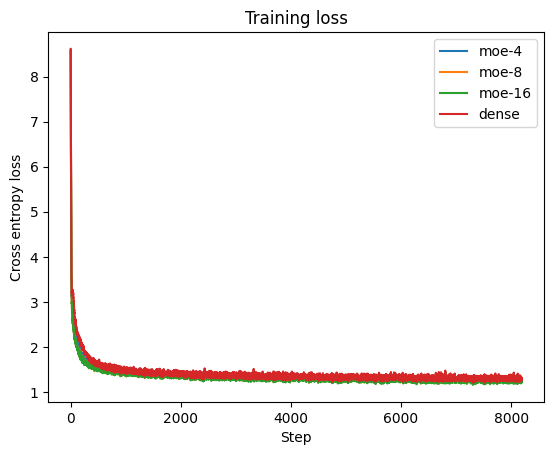

In [235]:
# Plot training loss

plt.figure()
plt.xlabel("Step")
plt.ylabel("Cross entropy loss")
plt.title("Training loss")
runs["dense"] = {"model": dense_model, "loss": dense_loss}
for name, run in runs.items():
    loss = run["loss"]
    plt.plot(loss.values(), label=name)
plt.legend()
plt.show()

Let's look at the average loss at the end of the training:

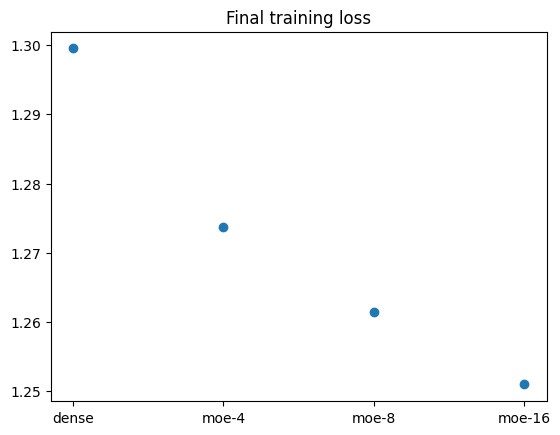

In [259]:
final_loss = {}
for name, run in runs.items():
    loss = run["loss"]
    final_loss[name] = np.mean(list(loss.values())[-100:])

final_loss = dict(sorted(final_loss.items(), key=lambda item: item[1], reverse=True))

plt.title("Final training loss")
plt.scatter(final_loss.keys(), final_loss.values())
plt.show()

#### Evaluating models

We can now test how our models perform and observe the effect of increasing the number of experts on the model performance. For this, we can either use models trained in the notebook, or one of the pre-trained models provided. We include pre-trained MoE models with 4, 8, and 16 experts.

We should observe that increasing the number of experts indeed improved the performance of the model! Note that importantly, this improvement comes without a proportional increase in compute cost - mixture of expert scheme only adds the routing logic overhead, but the processing FLOPs per token remain fixed.

#### Running MoE inference

Let's see our MoE models in action! We will run the inference on the CPU, so we need to make sure that any expert weights of the shape `(num_replicas, num_experts_per_replica, ...)` are reshaped to `(num_replicas * num_experts_per_replica, ...)` as expected by the CPU model.

In [236]:
def flatten_expert_weights(state_dict: dict, moe_layers: Tuple[int, ...]) -> dict:
    for i in moe_layers:
        w1 = state_dict[f"core_layers.{i}.ffn.w1"]
        w2 = state_dict[f"core_layers.{i}.ffn.w2"]
        state_dict[f"core_layers.{i}.ffn.w1"] = w1.reshape(-1, *w1.shape[2:])
        state_dict[f"core_layers.{i}.ffn.w2"] = w2.reshape(-1, *w2.shape[2:])
    return state_dict

We can also keep track of the router decisions by colouring each input character based on the expert it was routed to:

In [237]:
def wrap_text(text: str, id: int) -> str:
    col_id = id + 1 if id < 15 else id + 20
    return "\033[38;5;232m" + f"\033[48;5;{col_id}m" + text + "\033[0;0m"

In [238]:
# Set number of experts (can be 4, 8 or 16)
num_experts = 4

model_from_checkpoint = MoeCharModel(
    vocab_size=len(ds.vocab),
    hidden_size=128,
    expand_factor=4,
    kernel_size=7,
    num_groups=8,
    num_layers=8,
    dtype=torch.float32,
    num_replicas=1,
    num_experts_per_replica=num_experts,
    capacity_factor=1.0,
    moe_layers=(0, 2, 4, 6),
    aux_loss_weight=0.01,
)
state_dict = flatten_expert_weights(
    torch.load(checkpoint_dir / f"moe-{num_experts}.pt"), moe_layers=(0, 2, 4, 6)
)
model_from_checkpoint.load_state_dict(state_dict)

in_text = "This is a sentence to see how characters are routed to experts.\nSome numbers: 1, 2, 3, 4, 5, 6, 7, 8, 9.\n "
output = sample_text(
    model_from_checkpoint,
    in_text,
    num_characters=1,
    temperature=0.3,
)
for i in (0, 2, 4, 6):
    print(f"Layer {i}:")
    expert_ids = model_from_checkpoint.core_layers[i].ffn.expert_ids.numpy()
    colored_text = ""
    for c, id in zip(output, expert_ids):
        colored_text += wrap_text(c, id)
    print(colored_text)

This is a sentence to see how characters are routed to experts.
Some numbers: 1, 2, 3, 4, 5, 6, 7, 8, 9.
 )
Layer 0:
This is a sentence to see how characters are routed to experts.
Some numbers: 1, 2, 3, 4, 5, 6, 7, 8, 9.
 
Layer 2:
This is a sentence to see how characters are routed to experts.
Some numbers: 1, 2, 3, 4, 5, 6, 7, 8, 9.
 
Layer 4:
This is a sentence to see how characters are routed to experts.
Some numbers: 1, 2, 3, 4, 5, 6, 7, 8, 9.
 
Layer 6:
This is a sentence to see how characters are routed to experts.
Some numbers: 1, 2, 3, 4, 5, 6, 7, 8, 9.
 


## Conclusion

This notebook provided a tutorial on how to define a model that uses a mixture of experts execution scheme to increase the model capacity without a proportional increase in computational cost. Although the notebook covered defining a character-level language model, the techniques described here can be easily applied to making arbitrary expert-parallel layers. Moreover, by simply exchanging the FFN layers with `ExpertFFN` layers defined here and adding the expert-balancing loss to our final loss calculation, we can adapt arbitrary transformer-like models to utilise mixture of experts and run on both IPUs and CPU.